# The connection between DSRs and CSTRs
## Python imports

In [1]:
import scipy as sp
from scipy.integrate import odeint
import scipy.linalg
import scipy.optimize

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
from IPython.display import display

%matplotlib inline
plt.style.use("ggplot")

## Define system kinetics (rate field)

The 2D autocatalytic reaction:

$$A + B \rightarrow 2B$$
$$B \rightarrow C$$

is used used here for demonstration purposes. Rate constants are given by $k_1=1.0\,\mathrm{L.mol^{-1}s^{-1}}$ and $k_2=1.0\,\mathrm{L.mol^{-1}s^{-1}}$.

In [2]:
#Autocatalytic kinetics
def rate_fn(C,t):
    
    #Concentration vector: C = [cA, cB]
    cA = C[0]
    cB = C[1]
    
    #rate constants
    k1 = 1.0
    k2 = 1.0
    
    rA = -k1*cA*cB
    rB = k1*cA*cB - k2*cB**2
    
    dC = sp.array([rA, rB])
    return dC

## Define DSR function

The DSR equation is:

$$ \frac{\mathrm{d}\mathbf{C}}{\mathrm{d}\tau}=\mathbf{r}\left(\mathbf{C}\right)+\alpha\left(\mathbf{C}^{0}-\mathbf{C_{f}}\right) $$

which, compared to the PFR equation, is a function of two extra parameters: $\alpha$ and $\mathbf{C}^{0}$. The ODE's which are numerically integrated by Scipy's `odeint()` require a specific parameter sequence to be followed when defining functions. In this case, the extra parameters $\alpha$ and $\mathbf{C}^{0}$ are stored in a separate Python tuple named `opts`. The first element in `opts` is the value of $\alpha$, whereas the second elemenent is the side-stream composition $\mathbf{C}^{0}$.

In [3]:
def dsr_fn(C,t, opts):
    alpha = opts[0]
    C0 = opts[1]
    
    dC = rate_fn(C,t) + alpha*(C0 - C)
    return dC

## Solve CSTR locus
Later on in the notebook, we will demonstrate how constant $\alpha$ DSR trajectories approach a point on the CSTR locus when the side-stream composition equals of the DSR is equal to the feed composition in the CSTR.

We solve for the CSTR locus in a separate cell becuase the solution is computationally intensive. If we were to perform the calculation in real-time whilst ploting, the demonstration would be highly unresponsive.

In [4]:
cstr_ts = sp.logspace(-3,sp.log10(5e4),100)

cstr_cf = sp.array([1.0,0.1])
c_guess = cstr_cf

cstr_cs = []
for tau in cstr_ts:
    
    def cstr_fn(Ci):
        ri = rate_fn(Ci,[])
        f = cstr_cf + tau*ri - Ci
        
        return f
    
    #solve for CSTR solution
    Ci = scipy.optimize.newton_krylov(cstr_fn, c_guess, f_tol=1e-4)
    
    #update guess and add solution to cstr_cs array
    c_guess = Ci
    cstr_cs.append(Ci)
    
#convert array into a numpy array, useful for plotting later on
cstr_cs = sp.array(cstr_cs)

C:\Users\A0017697\Anaconda2\lib\site-packages\scipy\optimize\nonlin.py:474: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


## Plot DSR trajectory

In [5]:
def plot_fn(t_end=1000.0, alpha=0.0, Cf_x=1.0, Cf_y=0.1):
    Cf = sp.array([Cf_x, Cf_y])
    ts = sp.logspace(-3,sp.log10(t_end),100)

    #alpha = 0
    C0 = cstr_cf
    dsr_opts = (alpha, C0)

    #integrate DSR equation
    dsr_cs = odeint(dsr_fn, Cf, ts, args=(dsr_opts,) )
    
    #plot 
    plt.figure()
    plt.hold(True)
    
    #Overlay CSTR locus
    plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')

    #plot DSR trajectory
    plt.plot(dsr_cs[:,0],dsr_cs[:,1], 'g')
    plt.plot(dsr_cs[-1,0], dsr_cs[-1,1], 'ro')
    plt.plot(dsr_cs[0,0], dsr_cs[0,1], 'y^')

    plt.xlabel('cA (mol/L)')
    plt.ylabel('cB (mol/L)')
    plt.axis([0,1,0,0.7])
    plt.show()

## Interact

Use the sliders to interact with the plot. Change the initial condition of the DSR (it's feed concentration, given by the triangle in the plot), integration time and mixing policy and see that effect that is has on the resulting DSR solution trajectory. The DSR is integrated with a constant $\alpha$ value (it does not change with residence time). Notice how if the DSR residence time is made sufficiently long, the terminating concentration of the DSR (circle) approaches a point on the CSTR locus (crosses).

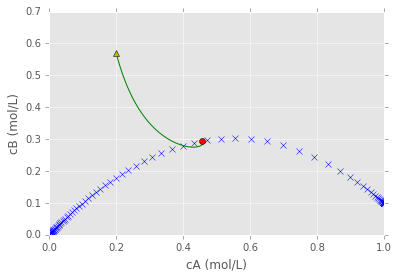

In [6]:
interactive(plot_fn, t_end=(1,100,1), alpha=(0.0,5.0,0.005), Cf_x=(0.0,1.0,0.01), Cf_y=(0.0,1.0,0.01))